In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, log_loss 

In [47]:
base_dir = '/data/ddmg/scate/multiple_shortcut/dr'
random_seed = 0 
pixel = 299 
batch_size = 64 
py1y0 = 0.9

In [48]:
def single_class_auc(y_cat_true, y_cat_pred, single_class):
    y_true = (y_cat_true == single_class) * 1
    y_pred = y_cat_pred[[f'predictions{single_class}']]
    return roc_auc_score(y_true, y_pred)
    

In [85]:
def get_per_dist_metrics(df):
    all_results = []
    for dist in [0.1, 0.5, 0.9]:
        curr_df = df[(df.dist==dist)]
        curr_eval = {'dist': dist}
        curr_eval['macro_auc'] = roc_auc_score(curr_df.y0, curr_df[
            [f'predictions{i}' for i in range(5)]], average='macro', multi_class='ovr')
        curr_eval['micro_auc'] = roc_auc_score(curr_df.y0, curr_df[
            [f'predictions{i}' for i in range(5)]], average='macro', multi_class='ovo')
        curr_eval['log_loss'] = log_loss(curr_df.y0, curr_df[
            [f'predictions{i}' for i in range(5)]])
        
        for single_class in range(5):
            curr_eval[f'auc{single_class}'] = single_class_auc(curr_df.y0, curr_df[
                [f'predictions{i}' for i in range(5)]], single_class)
        curr_eval['worst_auc'] = np.min([curr_eval[f'auc{i}'] for i in range(5)])
        all_results.append(curr_eval)
    return pd.DataFrame(all_results)
    
        
    

In [86]:
model_name = 'unweighted_baseline'
xv_mode = 'classic'
uw_pred = pd.read_csv(
    (f'{base_dir}/final_models/opt_pred_rs{random_seed}_{model_name}_{xv_mode}'
     f'_pix{pixel}_bs{batch_size}_py1y0{py1y0}.csv')) 
uw_eval = get_per_dist_metrics(uw_pred)

In [87]:
model_name = 'weighted_baseline'
xv_mode = 'classic'
w_pred = pd.read_csv(
    (f'{base_dir}/final_models/opt_pred_rs{random_seed}_{model_name}_{xv_mode}'
     f'_pix{pixel}_bs{batch_size}_py1y0{py1y0}.csv')) 
w_eval = get_per_dist_metrics(w_pred)

In [122]:
model_name = 'weighted_hsic'
xv_mode = 'classic'
wh_pred = pd.read_csv(
    (f'{base_dir}/final_models/opt_pred_rs{random_seed}_{model_name}_{xv_mode}'
     f'_pix{pixel}_bs{batch_size}_py1y0{py1y0}.csv')) 
wh_eval = get_per_dist_metrics(wh_pred)

In [123]:
eval_perf = {
    'uw_dnn': {'perf': uw_eval, 'label': "DNN", 'color':'black'  },  
    'w_dnn': {'perf': w_eval, 'label': "w-DNN", 'color':'#ABABAB'}, 
    'w_hsic': {'perf': wh_eval, 'label': "Ours", 'color':'#C85200'}
}

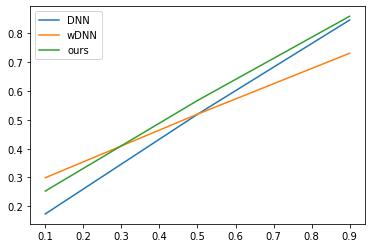

In [124]:
metric = 'macro_auc'
metric_label = 'Macro AUC'

plt.plot(uw_eval.dist, uw_eval[metric], label='DNN')
plt.plot(w_eval.dist, w_eval[metric], label='wDNN')
plt.plot(wh_eval.dist, wh_eval[metric], label='ours')
plt.legend()

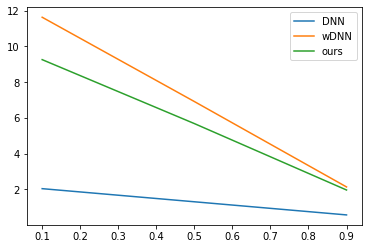

In [125]:
metric = 'log_loss'
metric_label = 'Macro AUC'

plt.plot(uw_eval.dist, uw_eval[metric], label='DNN')
plt.plot(w_eval.dist, w_eval[metric], label='wDNN')
plt.plot(wh_eval.dist, wh_eval[metric], label='ours')
plt.legend()

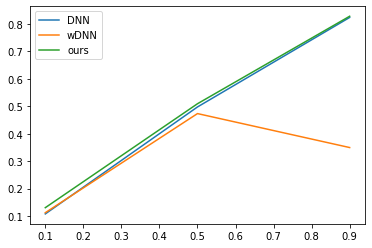

In [126]:
metric = 'worst_auc'
metric_label = 'Macro AUC'

plt.plot(uw_eval.dist, uw_eval[metric], label='DNN')
plt.plot(w_eval.dist, w_eval[metric], label='wDNN')
plt.plot(wh_eval.dist, wh_eval[metric], label='ours')
plt.legend()

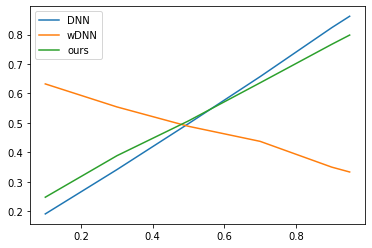

In [60]:
metric = 'auc1'
metric_label = 'Macro AUC'

plt.plot(uw_eval.dist, uw_eval[metric], label='DNN')
plt.plot(w_eval.dist, w_eval[metric], label='wDNN')
plt.plot(wh_eval.dist, wh_eval[metric], label='ours')
plt.legend()

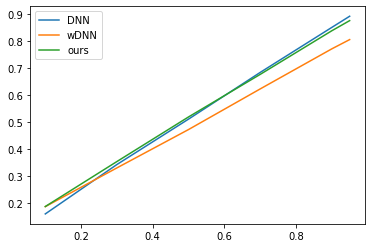

In [61]:
metric = 'auc2'
metric_label = 'Macro AUC'

plt.plot(uw_eval.dist, uw_eval[metric], label='DNN')
plt.plot(w_eval.dist, w_eval[metric], label='wDNN')
plt.plot(wh_eval.dist, wh_eval[metric], label='ours')
plt.legend()

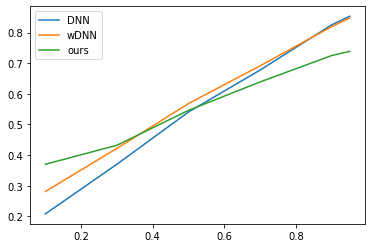

In [62]:
metric = 'auc3'
metric_label = 'Macro AUC'

plt.plot(uw_eval.dist, uw_eval[metric], label='DNN')
plt.plot(w_eval.dist, w_eval[metric], label='wDNN')
plt.plot(wh_eval.dist, wh_eval[metric], label='ours')
plt.legend()

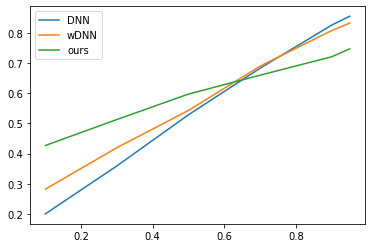

In [63]:
metric = 'auc4'
metric_label = 'Macro AUC'

plt.plot(uw_eval.dist, uw_eval[metric], label='DNN')
plt.plot(w_eval.dist, w_eval[metric], label='wDNN')
plt.plot(wh_eval.dist, wh_eval[metric], label='ours')
plt.legend()